In [1]:
%pylab notebook

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools

from copy import deepcopy

from primo.models.cas9_keras import log10_crispr_spec, log10_norm_crispr_spec, linear_crispr_spec

from primo.models.encoder import entropy_regularizer

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_gvuku_j because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


In [2]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=10**5
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar

# To see how this value was derived, please consult the Materials and Methods subsection under Feature Extraction section.
similarity_threshold = 75
# Intuitively determined:
batch_size = 150
val_batch_size = 150

train_batch_generator = keras_batch_generator(
    train_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)

val_batch_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(val_batch_size, similarity_threshold),
    similarity_threshold
)
        
train_inputs, train_targets = next(train_batch_generator)

switching to train_e.h5 and train_5.h5


In [3]:
OUTPUT_LEN = 20


encoder = tf.keras.Sequential([
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(2048, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(OUTPUT_LEN * 4, activation='relu'),
    layers.Reshape([OUTPUT_LEN, 4]),
    layers.Activation('softmax'),
    layers.Lambda(
        # Just using the identity because we don't want to transform the softmaxxed output,
        # we just want to make sure we learn an output encoding that's regularized (i.e. not crazy complex/over-fitting)
        lambda x: x,

        # In inference mode, this does nothing (just passes identity), but when training, this regularizes
        # the activations.
        # Using an "entropy" regulator because we passed the output through a softmax.
        activity_regularizer=entropy_regularizer(
            0.001
        )
    )

], name='encoder')

#encoder = tf.keras.models.load_model('/tf/primo/data/models/exp_encoder_2.h5')

# from primo.models.encoder import ClusteringLayer
# import pickle
# with open('/tf/primo/data/clusters_kmeans_64.pkl', 'rb') as f:
#     kmodel = pickle.loads(f.read())
# kmeans = kmodel.cluster_centers_
# encoder = tf.keras.Sequential([
#     ClusteringLayer(kmeans.shape[0], kmeans, input_dim=4096, alpha=25.0),
#     layers.Dense(1024, activation = 'relu'),
#     layers.Dense(OUTPUT_LEN * 4, activation='relu'),
#     layers.Reshape([OUTPUT_LEN, 4]),
#     layers.Activation('softmax'),
# ], name='encoder')

X_pairs = layers.Input([2, 4096])

# Essentially, we started with ]a batch of feature-vector pairs...
# ...And turned them into a pair of feature-vector batches.
X1, X2 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:]))(X_pairs)

distances = layers.Lambda(lambda Xs: tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)))([X1,X2])

# Independently transforms the batches of feature vectors into soft-max encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)

# Glue them back together! Back into a batch of feature vector pairs.
S_pairs = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2])

# Dimensions: (batch_size x 80 x 4 x 2 ) (i.e. batch size x DNA length x # of nucleotides x 2)

# Swaps dimensions for the predictor, which wants (batch-size x 2 x DNA length x 4)
S_pairs_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_pairs)

# y_h: Estimated output
y_h = layers.Lambda(tf.function(linear_crispr_spec(-1.3)))(S_pairs_T)
y_h_T = layers.Reshape([1])(y_h)
    
calcseq = tf.keras.Model(inputs=X_pairs, outputs=S_pairs_T)
calcdists = tf.keras.Model(inputs=X_pairs, outputs=distances)
encoder_trainer = tf.keras.Model(inputs=X_pairs, outputs=y_h_T)

print(encoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                163920    
_________________________________________________________________
reshape (Reshape)            (None, 20, 4)             0         
_________________________________________________________________
activation (Activation)      (None, 20, 4)             0   

In [19]:
def UniquenessMetric(y_true, y_pred):
    """Use a single batch of inputs to measure sequence uniqueness while training"""
    seqs = calcseq(train_inputs)
    # Reduce seqs to a single base (e.g. [0.6, 0.2, 0.1, 0.1] -> [0])
    rounded_seqs = K.argmax(seqs[:, 0, :, :], axis=-1)
    # Now each sample is array of 20 integers, 0-3. Multiply each position by 4**n to make
    # a unique integer for each possible 20bp sequence
    hashed_seqs = tf.reduce_sum(rounded_seqs * (4 ** tf.range(0, 20, dtype=tf.int64)), axis=-1)
    # Get unique ones
    unique_seqs, _ = tf.unique(hashed_seqs)
    # Return ratio of unique to input
    return float(len(unique_seqs)) / len(train_inputs)

def ConfidenceMetric(batch):
    """Uses a single batch of inputs to measure sequence uniqueness while training"""
    def confidence(_y_true, _y_pred):
        seqs = calcseq(batch)
        # Get the highest probabilty value for each base
        max_seqs = tf.reduce_max(seqs, axis=-1)
        # Take mean along both batch and seqence dimensions
        return tf.reduce_mean(max_seqs)
    return confidence

def OneHotAccuracy(y_true, y_pred):
    

In [20]:
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-3, clipnorm=1.0),
    'binary_crossentropy',
    run_eagerly=False,
    metrics=[UniquenessMetric, ConfidenceMetric(train_inputs), 'accuracy'])
history = encoder_trainer.fit(
    train_batch_generator,
    validation_data=val_batch_generator,
    validation_steps=5,
    steps_per_epoch=500,
    epochs=200)

Epoch 1/200
500/500 [==============================] - 28s 52ms/step - loss: 0.4005 - UniquenessMetric: 0.4843 - confidence: 0.8455 - accuracy: 0.8550 - val_loss: 0.4667 - val_UniquenessMetric: 0.4800 - val_confidence: 0.8453 - val_accuracy: 0.7987
Epoch 2/200
500/500 [==============================] - 26s 52ms/step - loss: 0.4020 - UniquenessMetric: 0.4807 - confidence: 0.8456 - accuracy: 0.8539 - val_loss: 0.4554 - val_UniquenessMetric: 0.4733 - val_confidence: 0.8448 - val_accuracy: 0.8147
Epoch 3/200
500/500 [==============================] - 26s 52ms/step - loss: 0.4026 - UniquenessMetric: 0.4893 - confidence: 0.8459 - accuracy: 0.8543 - val_loss: 0.5022 - val_UniquenessMetric: 0.4733 - val_confidence: 0.8460 - val_accuracy: 0.7947
Epoch 4/200
500/500 [==============================] - 26s 52ms/step - loss: 0.4053 - UniquenessMetric: 0.4899 - confidence: 0.8456 - accuracy: 0.8540 - val_loss: 0.4705 - val_UniquenessMetric: 0.5067 - val_confidence: 0.8453 - val_accuracy: 0.7893
Epoc

500/500 [==============================] - 26s 52ms/step - loss: 0.3826 - UniquenessMetric: 0.4556 - confidence: 0.8453 - accuracy: 0.8635 - val_loss: 0.4833 - val_UniquenessMetric: 0.4667 - val_confidence: 0.8444 - val_accuracy: 0.7987
Epoch 34/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3827 - UniquenessMetric: 0.4465 - confidence: 0.8453 - accuracy: 0.8658 - val_loss: 0.4991 - val_UniquenessMetric: 0.4400 - val_confidence: 0.8455 - val_accuracy: 0.7760
Epoch 35/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3826 - UniquenessMetric: 0.4427 - confidence: 0.8449 - accuracy: 0.8663 - val_loss: 0.5602 - val_UniquenessMetric: 0.4467 - val_confidence: 0.8444 - val_accuracy: 0.7787
Epoch 36/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3837 - UniquenessMetric: 0.4434 - confidence: 0.8452 - accuracy: 0.8637 - val_loss: 0.5097 - val_UniquenessMetric: 0.4400 - val_confidence: 0.8463 - val_accuracy: 0.7880
Epoch 37/200


500/500 [==============================] - 26s 53ms/step - loss: 0.3947 - UniquenessMetric: 0.4340 - confidence: 0.8474 - accuracy: 0.8605 - val_loss: 0.4945 - val_UniquenessMetric: 0.4333 - val_confidence: 0.8476 - val_accuracy: 0.7813
Epoch 65/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3946 - UniquenessMetric: 0.4408 - confidence: 0.8475 - accuracy: 0.8582 - val_loss: 0.4402 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8475 - val_accuracy: 0.8227
Epoch 66/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3925 - UniquenessMetric: 0.4215 - confidence: 0.8476 - accuracy: 0.8564 - val_loss: 0.4912 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8472 - val_accuracy: 0.7813
Epoch 67/200
500/500 [==============================] - 26s 51ms/step - loss: 0.3933 - UniquenessMetric: 0.4247 - confidence: 0.8476 - accuracy: 0.8587 - val_loss: 0.4942 - val_UniquenessMetric: 0.4400 - val_confidence: 0.8475 - val_accuracy: 0.7973
Epoch 68/200


500/500 [==============================] - 27s 53ms/step - loss: 0.3885 - UniquenessMetric: 0.4229 - confidence: 0.8483 - accuracy: 0.8629 - val_loss: 0.5252 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8496 - val_accuracy: 0.7840
Epoch 97/200
500/500 [==============================] - 27s 53ms/step - loss: 0.3842 - UniquenessMetric: 0.4095 - confidence: 0.8485 - accuracy: 0.8617 - val_loss: 0.5154 - val_UniquenessMetric: 0.4067 - val_confidence: 0.8493 - val_accuracy: 0.7813
Epoch 98/200
500/500 [==============================] - 27s 53ms/step - loss: 0.3814 - UniquenessMetric: 0.4140 - confidence: 0.8489 - accuracy: 0.8631 - val_loss: 0.4769 - val_UniquenessMetric: 0.4067 - val_confidence: 0.8487 - val_accuracy: 0.7893
Epoch 99/200
500/500 [==============================] - 27s 53ms/step - loss: 0.3817 - UniquenessMetric: 0.4153 - confidence: 0.8490 - accuracy: 0.8656 - val_loss: 0.4816 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8487 - val_accuracy: 0.7933
Epoch 100/200

500/500 [==============================] - 26s 52ms/step - loss: 0.3890 - UniquenessMetric: 0.4232 - confidence: 0.8486 - accuracy: 0.8623 - val_loss: 0.4263 - val_UniquenessMetric: 0.4267 - val_confidence: 0.8485 - val_accuracy: 0.8147
Epoch 128/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3891 - UniquenessMetric: 0.4223 - confidence: 0.8487 - accuracy: 0.8622 - val_loss: 0.4397 - val_UniquenessMetric: 0.4133 - val_confidence: 0.8498 - val_accuracy: 0.8147
Epoch 129/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3902 - UniquenessMetric: 0.4233 - confidence: 0.8490 - accuracy: 0.8631 - val_loss: 0.4550 - val_UniquenessMetric: 0.4133 - val_confidence: 0.8492 - val_accuracy: 0.8000
Epoch 130/200
500/500 [==============================] - 26s 53ms/step - loss: 0.3895 - UniquenessMetric: 0.4270 - confidence: 0.8483 - accuracy: 0.8616 - val_loss: 0.4797 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8488 - val_accuracy: 0.7947
Epoch 131/

500/500 [==============================] - 26s 52ms/step - loss: 0.3844 - UniquenessMetric: 0.4139 - confidence: 0.8489 - accuracy: 0.8665 - val_loss: 0.4807 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8486 - val_accuracy: 0.8000
Epoch 160/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3833 - UniquenessMetric: 0.4149 - confidence: 0.8483 - accuracy: 0.8658 - val_loss: 0.5326 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8478 - val_accuracy: 0.7827
Epoch 161/200
500/500 [==============================] - 26s 53ms/step - loss: 0.3826 - UniquenessMetric: 0.4176 - confidence: 0.8486 - accuracy: 0.8642 - val_loss: 0.4790 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8493 - val_accuracy: 0.7987
Epoch 162/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3783 - UniquenessMetric: 0.4221 - confidence: 0.8490 - accuracy: 0.8641 - val_loss: 0.4724 - val_UniquenessMetric: 0.4333 - val_confidence: 0.8484 - val_accuracy: 0.8013
Epoch 163/

500/500 [==============================] - 26s 52ms/step - loss: 0.3824 - UniquenessMetric: 0.4229 - confidence: 0.8500 - accuracy: 0.8621 - val_loss: 0.4351 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8501 - val_accuracy: 0.8333
Epoch 191/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3861 - UniquenessMetric: 0.4221 - confidence: 0.8500 - accuracy: 0.8609 - val_loss: 0.4311 - val_UniquenessMetric: 0.4133 - val_confidence: 0.8501 - val_accuracy: 0.8227
Epoch 192/200
500/500 [==============================] - 26s 53ms/step - loss: 0.3806 - UniquenessMetric: 0.4264 - confidence: 0.8497 - accuracy: 0.8624 - val_loss: 0.4338 - val_UniquenessMetric: 0.4333 - val_confidence: 0.8496 - val_accuracy: 0.8173
Epoch 193/200
500/500 [==============================] - 26s 52ms/step - loss: 0.3847 - UniquenessMetric: 0.4215 - confidence: 0.8500 - accuracy: 0.8619 - val_loss: 0.4453 - val_UniquenessMetric: 0.4200 - val_confidence: 0.8499 - val_accuracy: 0.8067
Epoch 194/

In [69]:
# encoder_trainer.compile(tf.keras.optimizers.Adagrad(1e-3), 'binary_crossentropy')
# history = encoder_trainer.fit(train_inputs, train_targets, epochs=300)

Epoch 1/300
5/5 [==============================] - 1s 6ms/step - loss: 0.3995
Epoch 2/300
5/5 [==============================] - 0s 6ms/step - loss: 0.3674
Epoch 3/300
5/5 [==============================] - 0s 6ms/step - loss: 0.3324
Epoch 4/300
5/5 [==============================] - 0s 6ms/step - loss: 0.3331
Epoch 5/300
5/5 [==============================] - 0s 6ms/step - loss: 0.3012
Epoch 6/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2716
Epoch 7/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2538
Epoch 8/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2638
Epoch 9/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2617
Epoch 10/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2436
Epoch 11/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2356
Epoch 12/300
5/5 [==============================] - 0s 6ms/step - loss: 0.2258
Epoch 13/300
5/5 [==============================] - 0s 6ms/st

5/5 [==============================] - 0s 6ms/step - loss: 0.1028
Epoch 105/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1041
Epoch 106/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1007
Epoch 107/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1067
Epoch 108/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1025
Epoch 109/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1123
Epoch 110/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1048
Epoch 111/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1042
Epoch 112/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1028
Epoch 113/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0984
Epoch 114/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1030
Epoch 115/300
5/5 [==============================] - 0s 6ms/step - loss: 0.1051
Epoch 116/300
5/5 [==============================] - 0

KeyboardInterrupt: 

In [24]:

encoder.save('/tf/primo/data/models/exp_encoder_x.h5')

<IPython.core.display.Javascript object>


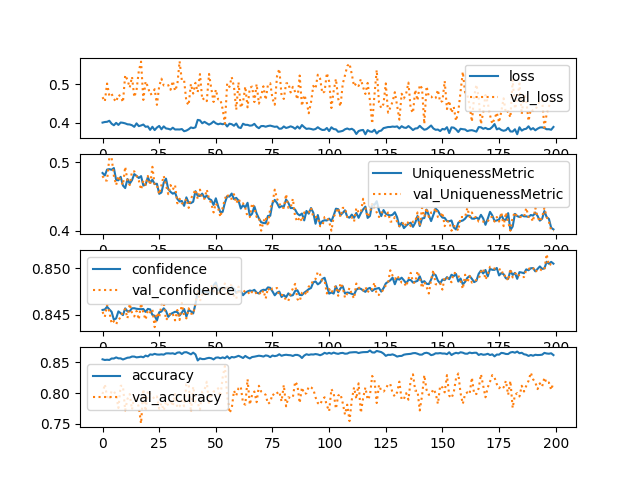

In [21]:
fig = plt.figure()
lines = [k for k in history.history.keys() if not k.startswith('val_')]

axes = fig.subplots(len(lines), 1)
for i in range(len(lines)):
    label = lines[i]
    ax = axes[i]
    val_label = 'val_' + label

    ax.plot(history.history[label], label=label)
    ax.plot(history.history[val_label], linestyle=':', label=val_label)
    ax.legend()

    

<IPython.core.display.Javascript object>


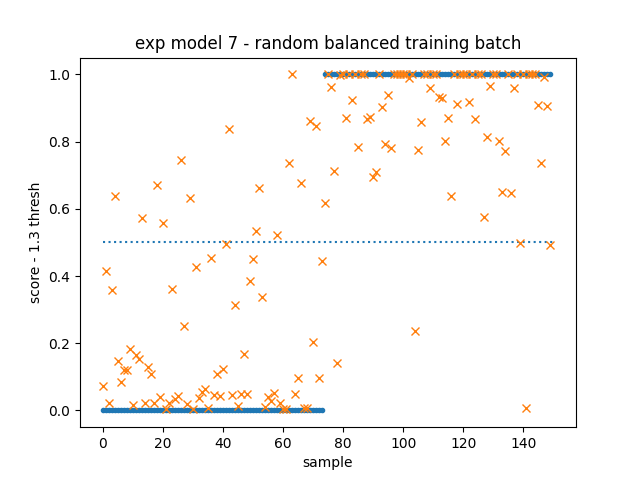

(150,)
(150,)


Text(0.5, 1.0, 'exp model 7 - random balanced training batch')

In [22]:
idx = train_targets.argsort()

Y = encoder_trainer.predict(train_inputs)
Y2 = 
seqs = calcseq.predict(train_inputs)
plt.figure()

print(train_targets.shape)
print((Y[:, 0] - train_targets).shape)
plt.plot(train_targets[idx], '.')
plt.plot(Y[idx][:, 0], 'x')
plt.hlines(0.5, 0, len(seqs), linestyle=':')
plt.ylabel('score - 1.3 thresh')
plt.xlabel('sample')
plt.title('exp model 7 - random balanced training batch')

<IPython.core.display.Javascript object>


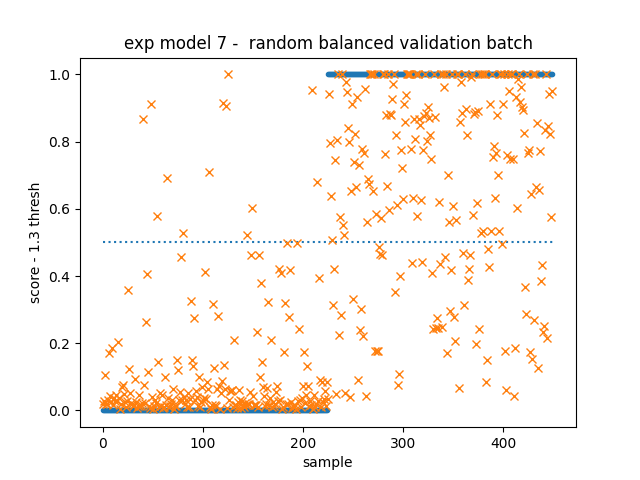

(450,)
(450,)


Text(0.5, 1.0, 'exp model 7 -  random balanced validation batch')

In [23]:
def get_batchs(n, generator):
    inputs = None
    target = None
    for _ in range(n):
        i, t = next(generator)
        if inputs is None:
            inputs = i
            targets = t
        else:
            inputs = np.concatenate([inputs, i])
            targets = np.concatenate([targets, t])
    return inputs, targets

#val_inputs, val_targets = next(val_batch_generator)
val_inputs, val_targets = get_batchs(3, val_batch_generator)

idx = val_targets.argsort()

Y = encoder_trainer.predict(val_inputs)
plt.figure()

print(val_targets.shape)
print((Y[:, 0] - val_targets).shape)
plt.plot(val_targets[idx], '.')
plt.plot(Y[idx][:, 0], 'x')
plt.hlines(0.5, 0, len(Y), linestyle=':')
plt.ylabel('score - 1.3 thresh')
plt.xlabel('sample')
plt.title('exp model 7 -  random balanced validation batch')



In [11]:
seqs = calcseq.predict(train_inputs)
all_seqs = seqs[:, 0, :, :] #np.concatenate([seqs[:, 0, :, :], seqs[:, 1, :, :]])

seq_strings = seqtools.onehots_to_seqs(all_seqs)
print(len(np.unique(all_seqs.argmax(-1), axis=0)))
unique = np.unique(seq_strings)
print(unique)
print(f"{len(unique)} / {len(all_seqs)}")



72
['CAAGACGGCCGCACTGAAAA' 'CAAGACGGTCGCACTGAAAA' 'CCAGACGGTCGCACTGAAAA'
 'CTAGACGGTCGCACTGAAAA' 'TAAGACGGACGCACTGAAAA' 'TAAGACGGCCACACTGAAAA'
 'TAAGACGGCCGCACTGAAAA' 'TAAGACGGTCACACTGAAAA' 'TAAGACGGTCGCACTGAAAA'
 'TACGACGCTCTCACTGAAAT' 'TACGACGGCCACACTGAAAA' 'TACGACGGCCGCACTGAAAA'
 'TACGACGGTCGCACTGAAAA' 'TACTACGCGCGCACGGAAAC' 'TACTACGTCCACACGGAAAT'
 'TACTGCGCGCTCACGGAAAC' 'TAGGACGGCCACACTGAAAA' 'TAGGACGGCCGCACTGAAAA'
 'TAGGACGGTCACACTGAAAA' 'TAGGACGGTCCCACTGAAAA' 'TAGGACGGTCGCACTGAAAA'
 'TAGGACGGTCTCACTGAAAA' 'TAGGACGGTCTCACTGAAAG' 'TAGGACGTTCTCACTGAAAG'
 'TAGTGAGTGCTCACGGAAAC' 'TATTACGGACGCACTGAAAA' 'TCAGACGGACGCACTGAAAA'
 'TCCGACGGACGCACTGAAAA' 'TCCGACGGCCGCACTGAAAA' 'TCCGACGGTCGCACTGAAAA'
 'TCCTACGCGCACACGGAAAT' 'TCCTACGCTCCCACGGAAAT' 'TCCTACGCTCTCACGGAAAT'
 'TCCTACGGACGCACTGAAAA' 'TCCTACGGGCGCACTGAAAA' 'TCGGACGGCCACACTGAAAA'
 'TCGGACGTTCCCACGGAAAG' 'TCGTACGCCCACACGGAAAT' 'TCGTACGCCCCCACGGAAAC'
 'TCGTACGGCCGCACTGAAAA' 'TCTGACGGACGCACTGAAAA' 'TCTGACGGTCGCACTGAAAA'
 'TCTTACGCGCGCACG

In [18]:
all_seqs[7]

array([[0.00333693, 0.9899893 , 0.00333693, 0.00333693],
       [0.22694145, 0.24425125, 0.27815652, 0.25065082],
       [0.23219538, 0.2819585 , 0.25365072, 0.23219538],
       [0.23225082, 0.6456381 , 0.06428759, 0.05782351],
       [0.5236062 , 0.10427291, 0.09229853, 0.27982232],
       [0.07805529, 0.03192632, 0.8580921 , 0.03192632],
       [0.00319229, 0.00319229, 0.00319229, 0.9904231 ],
       [0.05635713, 0.35138175, 0.535904  , 0.05635713],
       [0.21648732, 0.07278113, 0.22385861, 0.48687303],
       [0.00915403, 0.00915403, 0.9725379 , 0.00915403],
       [0.1738564 , 0.13498202, 0.12751456, 0.56364703],
       [0.00953625, 0.01210224, 0.969872  , 0.00848958],
       [0.98716694, 0.00427771, 0.00427771, 0.00427771],
       [0.00378281, 0.00378281, 0.98804945, 0.00438489],
       [0.0809309 , 0.16193402, 0.09562994, 0.66150516],
       [0.00678979, 0.00668144, 0.00668144, 0.9798473 ],
       [0.9866355 , 0.00445482, 0.00445482, 0.00445482],
       [0.98578656, 0.00437462,

In [9]:
# weights = [tensor for tensor in encoder_trainer.trainable_weights]# if encoder_trainer.get_layer(tensor.name[:-2]).trainable]
# optimizer = encoder_trainer.optimizer
# loss = tf.keras.metrics.BinaryCrossentropy(from_logits=False)(y_h_T, train_targets)
# g = optimizer.get_gradients(loss, weights)

with tf.GradientTape() as tape:
    # Doing the computation in the context of the gradient tape
    # For example computing loss
    pred = encoder_trainer(train_inputs)
    loss = tf.metrics.MSE(train_targets,pred)
    
# Getting the gradient of weight w.r.t loss 
grad = tape.gradient(loss, encoder_trainer.trainable_weights) 
print(grad)
#print([tf.norm(g).numpy() for g in grad])

[<tf.Tensor: shape=(4096, 2048), dtype=float32, numpy=
array([[-0.00668996, -0.00442752, -0.01292114, ..., -0.00297812,
         0.00866672,  0.00046856],
       [-0.014083  , -0.0085131 , -0.01540488, ..., -0.00662993,
         0.01435623,  0.00218737],
       [-0.00739208, -0.00459306, -0.00793888, ..., -0.00424623,
         0.00936238,  0.00140106],
       ...,
       [-0.00707141, -0.0031601 , -0.00536229, ..., -0.00655378,
         0.01212534,  0.0022773 ],
       [-0.01130053, -0.00968682, -0.01601881, ..., -0.00374336,
         0.00950455,  0.00092499],
       [-0.00697468, -0.0061232 , -0.00847617, ..., -0.0014009 ,
         0.00568788,  0.00132537]], dtype=float32)>, <tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([-0.01711289, -0.01263236, -0.01965856, ..., -0.00607363,
        0.01729374,  0.0022029 ], dtype=float32)>, <tf.Tensor: shape=(2048, 2048), dtype=float32, numpy=
array([[ 5.5676320e-04,  7.4185044e-02,  7.9013333e-02, ...,
        -1.9020287e-02, -2.8113823e-

In [10]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

<IPython.core.display.Javascript object>

In [11]:
sample_input = train_inputs[0]
inspect_layers = [encoder.model.layers[0].output, encoder.model.layers[3].output]
layers_model = tf.keras.Model(inputs=encoder.model.input, outputs=inspect_layers)
Y = layers_model.predict(sample_input)
print(Y)
plt.figure()
plt.plot(Y[0].T, '.')

AttributeError: 'Sequential' object has no attribute 'model'

In [ ]:
sim = primo.models.Simulator()
from primo.models.cas9 import crispr_specificity
crispr_specificity('TATGTAGAAAACTGCAAAAC', 'TATGTAGAAAACTGCAAAAC')

In [ ]:
x = np.array([[all_seqs[0], all_seqs[1]]])
print(x.shape)
print(f"linear: {linear_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
print(f"log10norm: {log10_norm_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
all_seqs[0].shape

In [ ]:
print(np.around(all_seqs[0], 4))